In [ ]:
# STEP 1: IMPORTS & SETUP

# Core libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Metrics and evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns

# Check GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Found 494 images belonging to 2 classes.
Found 123 images belonging to 2 classes.

✅ Training only on these classes: {'Defect': 0, 'No Defect': 1}


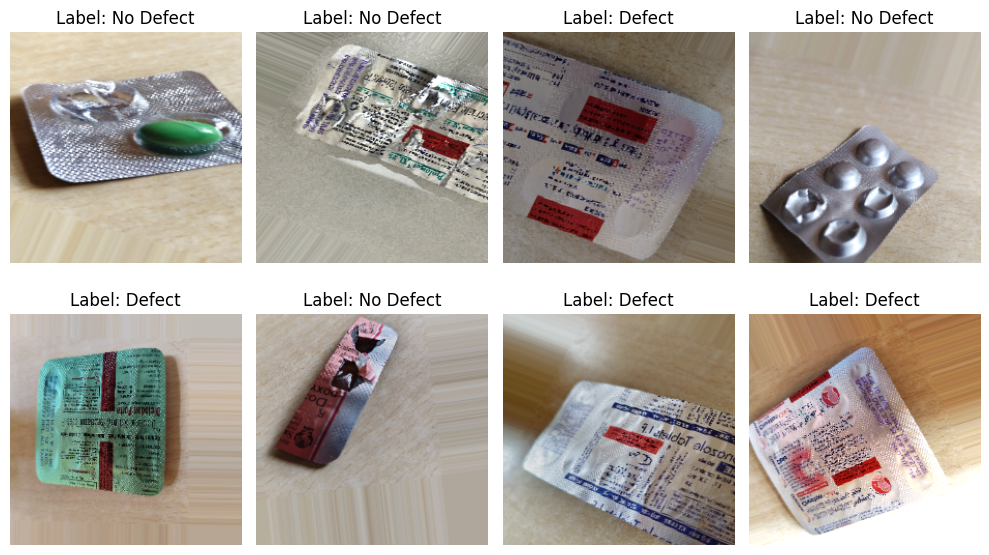

In [ ]:
# STEP 2 (UPDATED): LOAD ONLY 2 CLASSES — 'Defect' & 'No Defect'

import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

# Define dataset path
dataset_path = "/content/sample_data/Seal Integrity "

# Filter only these two class folders
allowed_classes = ['Defect', 'No Defect']

# Temporary subfolder copy (only these 2)
filtered_dataset_path = "/content/temp_filtered_dataset"
os.makedirs(filtered_dataset_path, exist_ok=True)

for cls in allowed_classes:
    src = os.path.join(dataset_path, cls)
    dst = os.path.join(filtered_dataset_path, cls)
    if os.path.exists(src):
        os.system(f'cp -r "{src}" "{filtered_dataset_path}"')
    else:
        print(f"⚠️ Warning: Folder '{cls}' not found in dataset!")

# Image parameters
img_height, img_width = 224, 224
batch_size = 16

# Strong augmentation (for small dataset)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest',
    validation_split=0.2
)

# Train generator
train_generator = train_datagen.flow_from_directory(
    filtered_dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    filtered_dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Confirm the classes loaded
print("\n✅ Training only on these classes:", train_generator.class_indices)

# Show a few augmented samples
sample_images, sample_labels = next(train_generator)
plt.figure(figsize=(10, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(sample_images[i] / 255.0)
    plt.title("Label: " + ("Defect" if sample_labels[i] == 1 else "No Defect"))
    plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
# STEP 3: BUILD MODEL (EfficientNetB0)

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Define base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze base layers for feature extraction (can unfreeze later for fine-tuning)
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

# Build model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,            # you can increase this if training stabilizes well
    callbacks=[early_stop, checkpoint],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 275s 8s/step - accuracy: 0.7036 - loss: 0.4860 - val_accuracy: 0.8049 - val_loss: 0.4199
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 218s 7s/step - accuracy: 0.9392 - loss: 0.1794 - val_accuracy: 0.9106 - val_loss: 0.2679
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 216s 7s/step - accuracy: 0.9609 - loss: 0.1357 - val_accuracy: 0.8862 - val_loss: 0.3454
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 218s 7s/step - accuracy: 0.9710 - loss: 0.0978 - val_accuracy: 0.8862 - val_loss: 0.3189
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 205s 7s/step - accuracy: 0.9637 - loss: 0.1109 - val_accuracy: 0.8862 - val_loss: 0.3752
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 200s 6s/step - accuracy: 0.9756 - loss: 0.0627 - val_accuracy: 0.8618 - val_loss: 0.4378
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 208s 7s/step - accuracy: 0.9754 - loss: 0.0796 - val_accuracy: 0.9187 - val_loss: 0.2306
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 205s 7s/step - accuracy: 0.9669 - loss: 0.0775 - val_accuracy: 0.9106 - v

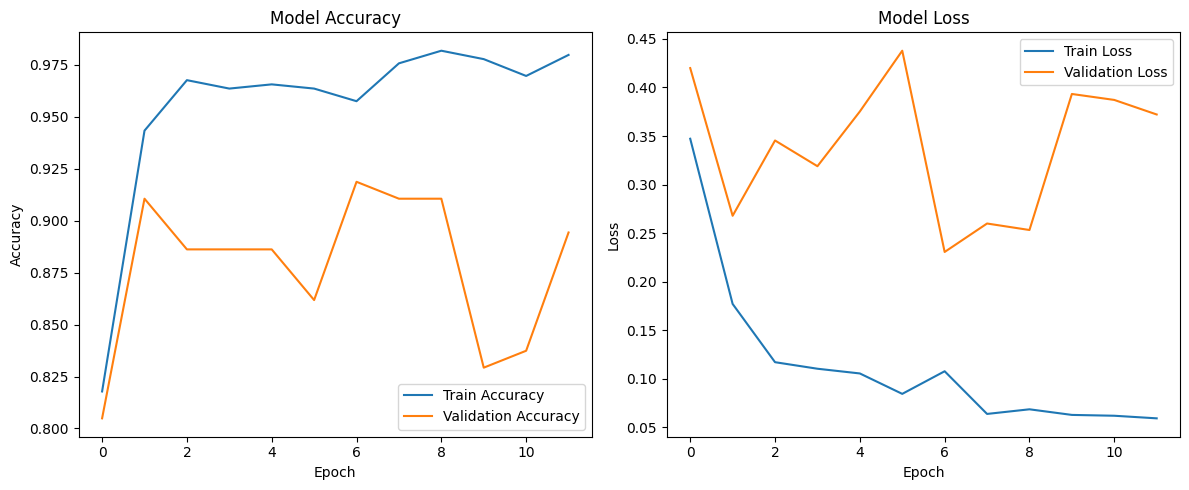

In [23]:
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step


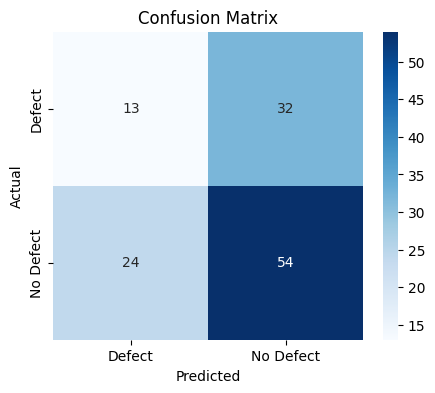


Classification Report:
              precision    recall  f1-score   support

      Defect       0.35      0.29      0.32        45
   No Defect       0.63      0.69      0.66        78

    accuracy                           0.54       123
   macro avg       0.49      0.49      0.49       123
weighted avg       0.53      0.54      0.53       123



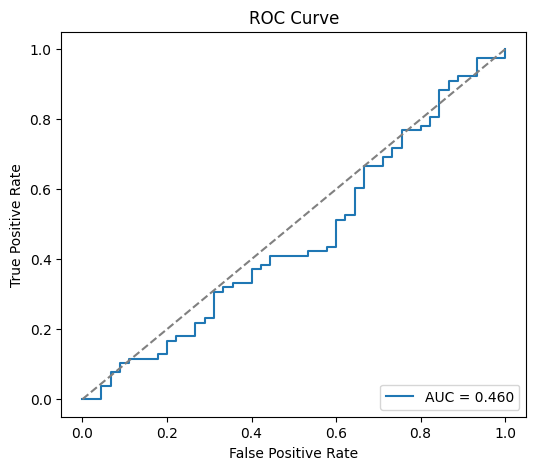

In [24]:
# STEP 5: MODEL EVALUATION METRICS

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Make predictions on validation data
val_generator.reset()
pred_probs = model.predict(val_generator)
pred_classes = (pred_probs > 0.5).astype("int32").ravel()

# True labels
true_classes = val_generator.classes

# --- Confusion Matrix ---
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Defect', 'No Defect'],
            yticklabels=['Defect', 'No Defect'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(true_classes, pred_classes, target_names=['Defect','No Defect']))

# --- AUC-ROC ---
roc_auc = roc_auc_score(true_classes, pred_probs)
fpr, tpr, _ = roc_curve(true_classes, pred_probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


🖼️ Testing image: /content/sample_data/Seal Integrity /Defect/IMG_20250817_105258.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


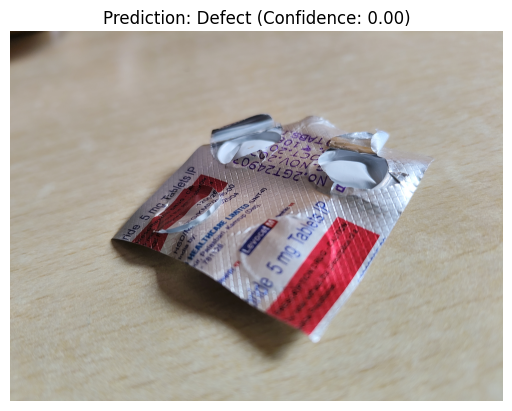

In [28]:
# STEP 6 (UPDATED): LIVE TESTING ON RANDOM IMAGE FROM DATASET

import os
import random
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Path to your dataset
dataset_path = "/content/sample_data/Seal Integrity "

# Randomly pick one image from either 'Defect' or 'No Defect'
subfolders = ['Defect', 'No Defect']
chosen_folder = random.choice(subfolders)
folder_path = os.path.join(dataset_path, chosen_folder)
random_image = random.choice(os.listdir(folder_path))
test_image_path = os.path.join(folder_path, random_image)

print(f"🖼️ Testing image: {test_image_path}")

# Load and preprocess the image
img = image.load_img(test_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_preprocessed = preprocess_input(np.expand_dims(img_array, axis=0))

# Predict
pred_prob = model.predict(img_preprocessed)[0][0]
pred_class = "No Defect" if pred_prob > 0.5 else "Defect"

# Show result
img_display = cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB)
plt.imshow(img_display)
plt.title(f"Prediction: {pred_class} (Confidence: {pred_prob:.2f})")
plt.axis("off")
plt.show()
